In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
import warnings
import time
from scipy.stats import randint, uniform
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Step 1: Load & Prepare Data
# Load featured dataset
print("Loading data...")
df = pd.read_csv('beijing_air_quality_featured.csv', index_col='datetime', parse_dates=True)

# Separate features and target
X = df.drop(columns=['target_pm2.5', 'pm2.5_original'])
if 'pm2.5' in X.columns:
    X = X.drop(columns=['pm2.5'])
y = df['target_pm2.5']

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Sort by time
X = X.sort_index()
y = y.sort_index()

print(f"Data shape: {X.shape}")
print(f"Time range: {X.index[0]} to {X.index[-1]}")

Loading data...
Data shape: (41756, 46)
Time range: 2010-01-02 00:00:00 to 2014-12-31 22:00:00


In [4]:
# Step 2: Time-Series CV Setup
# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3, test_size=24*30)  # 3 folds for tuning (faster)
print(f"Time-series CV: {tscv.n_splits} folds")

Time-series CV: 3 folds


In [5]:
# Step 3: Baseline Models (No Tuning)
def train_baseline_models(X, y, tscv):
    """Train and evaluate baseline models"""
    
    baseline_results = {}
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, max_depth=10, min_samples_split=5,
            n_jobs=-1, random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbose=-1
        )
    }
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        fold_scores = {'mae': [], 'rmse': [], 'mape': [], 'r2': [], 'time': []}
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            # Split
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train
            start = time.time()
            model.fit(X_train_scaled, y_train)
            train_time = time.time() - start
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            
            # Metrics
            fold_scores['mae'].append(mean_absolute_error(y_test, y_pred))
            fold_scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_scores['mape'].append(mean_absolute_percentage_error(y_test, y_pred) * 100)
            fold_scores['r2'].append(r2_score(y_test, y_pred))
            fold_scores['time'].append(train_time)
        
        # Store average results
        baseline_results[model_name] = {
            'MAE': np.mean(fold_scores['mae']),
            'RMSE': np.mean(fold_scores['rmse']),
            'MAPE': np.mean(fold_scores['mape']),
            'R2': np.mean(fold_scores['r2']),
            'Time': np.mean(fold_scores['time'])
        }
        
        print(f"  MAE:  {baseline_results[model_name]['MAE']:.2f}")
        print(f"  RMSE: {baseline_results[model_name]['RMSE']:.2f}")
        print(f"  MAPE: {baseline_results[model_name]['MAPE']:.2f}%")
        print(f"  R²:   {baseline_results[model_name]['R2']:.4f}")
        print(f"  Time: {baseline_results[model_name]['Time']:.2f}s")
    
    return baseline_results, models

print("\n" + "="*60)
print("BASELINE MODEL EVALUATION")
print("="*60)
baseline_results, baseline_models = train_baseline_models(X, y, tscv)


BASELINE MODEL EVALUATION

Evaluating Linear Regression...
  MAE:  21.01
  RMSE: 33.69
  MAPE: 48.27%
  R²:   0.8932
  Time: 0.08s

Evaluating Random Forest...
  MAE:  19.86
  RMSE: 32.95
  MAPE: 39.19%
  R²:   0.8989
  Time: 12.10s

Evaluating XGBoost...
  MAE:  20.28
  RMSE: 33.12
  MAPE: 37.06%
  R²:   0.8994
  Time: 0.94s

Evaluating LightGBM...
  MAE:  19.07
  RMSE: 31.41
  MAPE: 37.68%
  R²:   0.9079
  Time: 0.45s


In [6]:
# Step 4: Hyperparameter Tuning
def tune_model(model_name, model, param_grid, X, y, tscv):
    """Perform randomized search for hyperparameter tuning"""
    
    print(f"\nTuning {model_name}...")
    
    # Use first fold for tuning (to save time)
    train_idx, test_idx = list(tscv.split(X))[0]
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Randomized search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=3,  # 3-fold CV on training data
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    # Fit
    start = time.time()
    random_search.fit(X_train_scaled, y_train)
    tune_time = time.time() - start
    
    # Best model
    best_model = random_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    
    print(f"  Best params: {random_search.best_params_}")
    print(f"  MAE:  {mae:.2f} (improvement: {(baseline_results[model_name]['MAE'] - mae):.2f})")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  Tuning time: {tune_time:.2f}s")
    
    return best_model, random_search.best_params_, {
        'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Time': tune_time
    }

# Hyperparameter grids
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# XGBoost tuning
xgb_param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),  # range 0.6-1.0
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

best_xgb, xgb_best_params, xgb_tuned_results = tune_model(
    'XGBoost', 
    XGBRegressor(n_jobs=-1, random_state=42),
    xgb_param_grid, X, y, tscv
)

# LightGBM tuning
lgbm_param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 100),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'min_child_samples': randint(10, 50)
}

best_lgbm, lgbm_best_params, lgbm_tuned_results = tune_model(
    'LightGBM',
    LGBMRegressor(n_jobs=-1, random_state=42, verbose=-1),
    lgbm_param_grid, X, y, tscv
)

# Random Forest tuning (optional)
rf_param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

best_rf, rf_best_params, rf_tuned_results = tune_model(
    'Random Forest',
    RandomForestRegressor(n_jobs=-1, random_state=42),
    rf_param_grid, X, y, tscv
)


HYPERPARAMETER TUNING

Tuning XGBoost...
  Best params: {'colsample_bytree': np.float64(0.6976502088991097), 'gamma': np.float64(0.16829104217293056), 'learning_rate': np.float64(0.07562926587192106), 'max_depth': 3, 'n_estimators': 229, 'reg_alpha': np.float64(0.363629602379294), 'reg_lambda': np.float64(0.9717820827209607), 'subsample': np.float64(0.9849789179768444)}
  MAE:  18.20 (improvement: 2.07)
  RMSE: 27.96
  MAPE: 30.84%
  R²:   0.9444
  Tuning time: 52.06s

Tuning LightGBM...
  Best params: {'colsample_bytree': np.float64(0.8886918084659492), 'learning_rate': np.float64(0.08079547592468672), 'max_depth': 8, 'min_child_samples': 48, 'n_estimators': 76, 'num_leaves': 28, 'reg_alpha': np.float64(0.7106628896857874), 'reg_lambda': np.float64(0.11089082081183133), 'subsample': np.float64(0.7757346007463081)}
  MAE:  18.13 (improvement: 0.94)
  RMSE: 27.84
  MAPE: 30.44%
  R²:   0.9449
  Tuning time: 33.37s

Tuning Random Forest...
  Best params: {'max_depth': 15, 'max_features'

In [7]:
# Step 5: Final Model Comparison

def evaluate_final_models(models_dict, X, y, tscv):
    """Evaluate all models with proper CV"""
    
    final_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\nEvaluating {model_name}...")
        
        fold_scores = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}
        all_predictions = []
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            # Split
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train
            model.fit(X_train_scaled, y_train)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            
            # Store predictions for visualization
            for true_val, pred_val in zip(y_test, y_pred):
                all_predictions.append({
                    'model': model_name,
                    'true': true_val,
                    'pred': pred_val,
                    'fold': fold
                })
            
            # Metrics
            fold_scores['mae'].append(mean_absolute_error(y_test, y_pred))
            fold_scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_scores['mape'].append(mean_absolute_percentage_error(y_test, y_pred) * 100)
            fold_scores['r2'].append(r2_score(y_test, y_pred))
        
        # Store results
        final_results[model_name] = {
            'MAE': (np.mean(fold_scores['mae']), np.std(fold_scores['mae'])),
            'RMSE': (np.mean(fold_scores['rmse']), np.std(fold_scores['rmse'])),
            'MAPE': (np.mean(fold_scores['mape']), np.std(fold_scores['mape'])),
            'R2': (np.mean(fold_scores['r2']), np.std(fold_scores['r2'])),
            'predictions': all_predictions
        }
        
        print(f"  MAE:  {final_results[model_name]['MAE'][0]:.2f} ± {final_results[model_name]['MAE'][1]:.2f}")
        print(f"  RMSE: {final_results[model_name]['RMSE'][0]:.2f} ± {final_results[model_name]['RMSE'][1]:.2f}")
        print(f"  MAPE: {final_results[model_name]['MAPE'][0]:.2f}% ± {final_results[model_name]['MAPE'][1]:.2f}")
        print(f"  R²:   {final_results[model_name]['R2'][0]:.4f} ± {final_results[model_name]['R2'][1]:.4f}")
    
    return final_results

# Define final models to compare
final_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest (Tuned)': RandomForestRegressor(**rf_best_params, n_jobs=-1, random_state=42),
    'XGBoost (Tuned)': XGBRegressor(**xgb_best_params, n_jobs=-1, random_state=42),
    'LightGBM (Tuned)': LGBMRegressor(**lgbm_best_params, n_jobs=-1, random_state=42, verbose=-1)
}

print("\n" + "="*60)
print("FINAL MODEL COMPARISON (3-FOLD CV)")
print("="*60)
final_results = evaluate_final_models(final_models, X, y, tscv)


FINAL MODEL COMPARISON (3-FOLD CV)

Evaluating Linear Regression...
  MAE:  21.01 ± 0.97
  RMSE: 33.69 ± 3.20
  MAPE: 48.27% ± 10.40
  R²:   0.8932 ± 0.0373

Evaluating Random Forest (Tuned)...
  MAE:  19.79 ± 0.91
  RMSE: 33.02 ± 3.31
  MAPE: 39.72% ± 7.68
  R²:   0.8972 ± 0.0368

Evaluating XGBoost (Tuned)...
  MAE:  19.28 ± 0.82
  RMSE: 31.93 ± 2.85
  MAPE: 40.30% ± 6.91
  R²:   0.9042 ± 0.0330

Evaluating LightGBM (Tuned)...
  MAE:  19.06 ± 0.72
  RMSE: 31.53 ± 2.65
  MAPE: 40.45% ± 7.09
  R²:   0.9069 ± 0.0312



VISUALIZING RESULTS


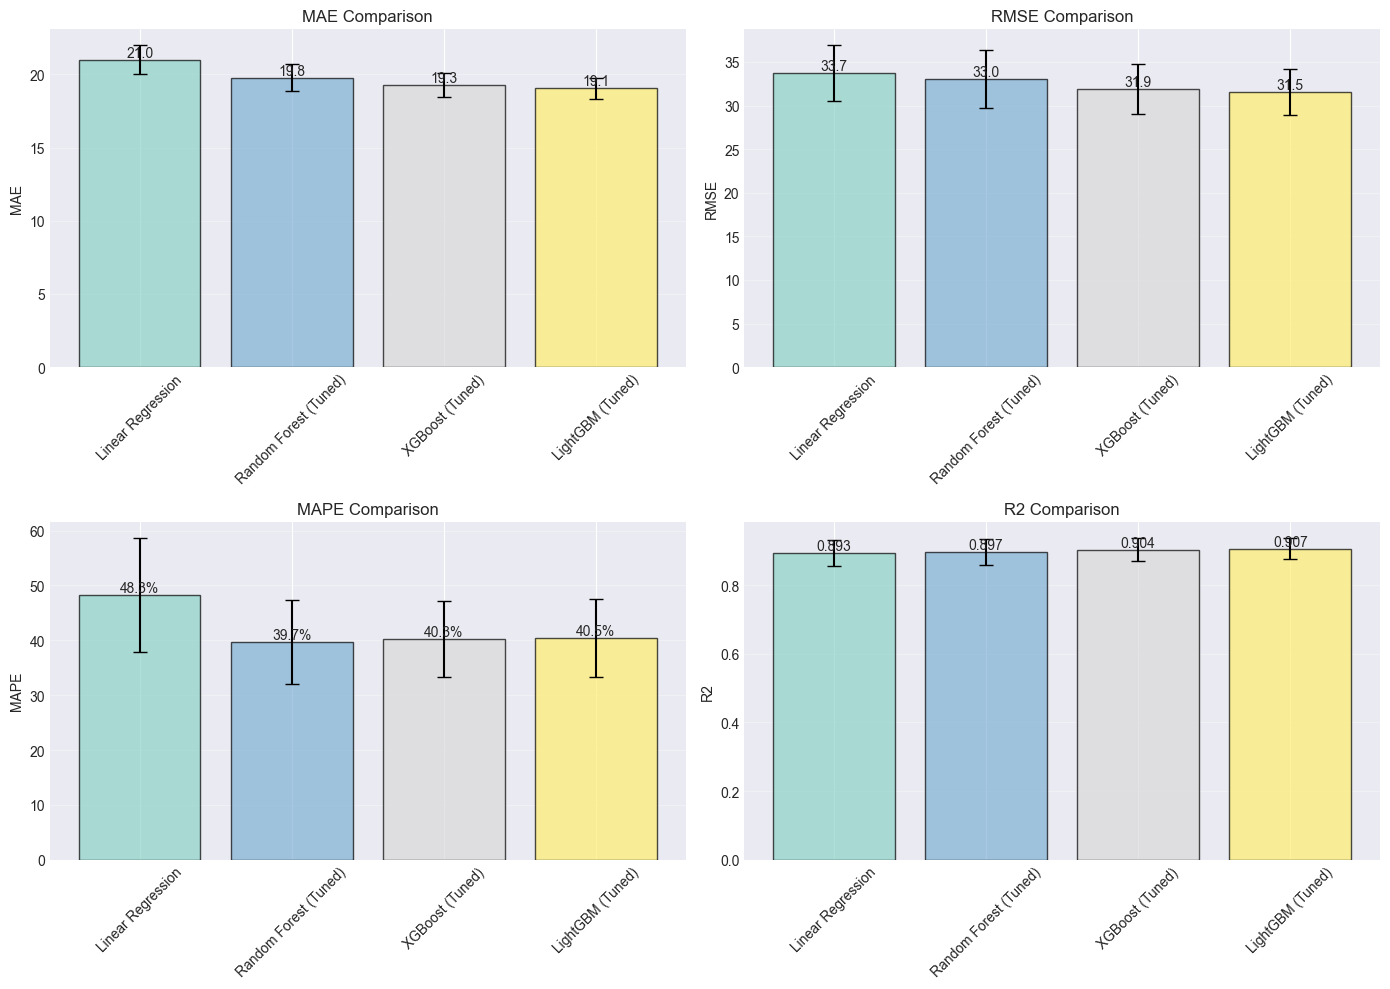


Final Model Performance:
                Model          MAE         RMSE    MAPE (%)              R²
    Linear Regression 21.01 ± 0.97 33.69 ± 3.20 48.3 ± 10.4 0.8932 ± 0.0373
Random Forest (Tuned) 19.79 ± 0.91 33.02 ± 3.31  39.7 ± 7.7 0.8972 ± 0.0368
      XGBoost (Tuned) 19.28 ± 0.82 31.93 ± 2.85  40.3 ± 6.9 0.9042 ± 0.0330
     LightGBM (Tuned) 19.06 ± 0.72 31.53 ± 2.65  40.5 ± 7.1 0.9069 ± 0.0312


In [8]:
# Step 6: Visualization & Analysis
def create_comparison_plots(final_results):
    """Create visualization plots for model comparison"""
    
    # Prepare data for plotting
    model_names = list(final_results.keys())
    metrics = ['MAE', 'RMSE', 'MAPE', 'R2']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        values = [final_results[model][metric][0] for model in model_names]
        errors = [final_results[model][metric][1] for model in model_names]
        
        bars = axes[idx].bar(model_names, values, yerr=errors, 
                           capsize=5, alpha=0.7, edgecolor='black')
        
        # Color bars
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        for bar, color in zip(bars, colors):
            bar.set_facecolor(color)
        
        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if metric == 'MAPE':
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{value:.1f}%', ha='center', va='bottom')
            elif metric == 'R2':
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{value:.3f}', ha='center', va='bottom')
            else:
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{value:.1f}', ha='center', va='bottom')
        
        axes[idx].set_ylabel(metric)
        axes[idx].set_title(f'{metric} Comparison')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create results table
    results_df = pd.DataFrame([
        {
            'Model': model,
            'MAE': f"{final_results[model]['MAE'][0]:.2f} ± {final_results[model]['MAE'][1]:.2f}",
            'RMSE': f"{final_results[model]['RMSE'][0]:.2f} ± {final_results[model]['RMSE'][1]:.2f}",
            'MAPE (%)': f"{final_results[model]['MAPE'][0]:.1f} ± {final_results[model]['MAPE'][1]:.1f}",
            'R²': f"{final_results[model]['R2'][0]:.4f} ± {final_results[model]['R2'][1]:.4f}"
        }
        for model in model_names
    ])
    
    return results_df

# Create plots and results table
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)
results_df = create_comparison_plots(final_results)
print("\nFinal Model Performance:")
print(results_df.to_string(index=False))


FEATURE IMPORTANCE ANALYSIS


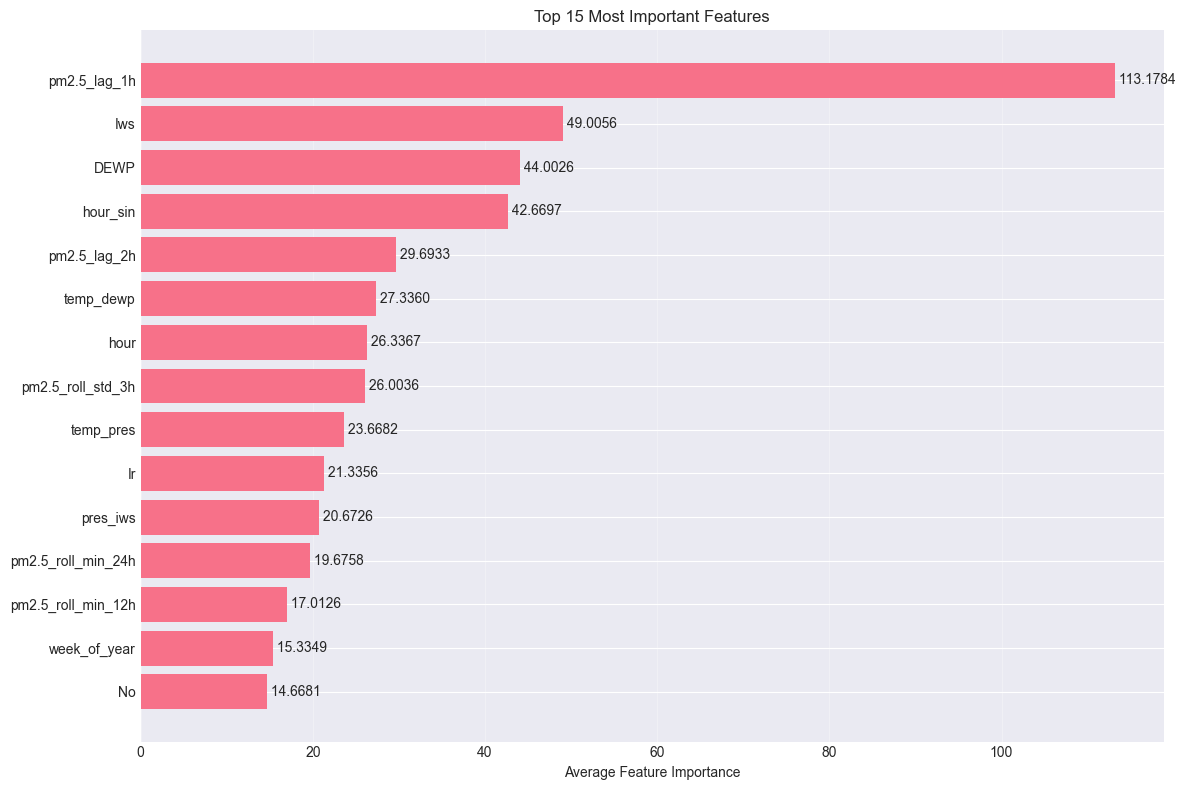


Top 10 Most Important Features:
                   XGBoost (Tuned)  LightGBM (Tuned)  Random Forest (Tuned)  Avg_Importance
pm2.5_lag_1h              0.346828               339               0.188306      113.178378
Iws                       0.010381               147               0.006343       49.005574
DEWP                      0.003973               132               0.003906       44.002626
hour_sin                  0.005757               128               0.003426       42.669728
pm2.5_lag_2h              0.003841                89               0.075931       29.693257
temp_dewp                 0.004793                82               0.003311       27.336035
hour                      0.006212                79               0.003948       26.336720
pm2.5_roll_std_3h         0.003401                78               0.007519       26.003640
temp_pres                 0.002265                71               0.002399       23.668221
Ir                        0.006017             

In [9]:
# Step 7: Feature Importance Analysis
def analyze_feature_importance(best_models, X, y):
    """Analyze feature importance from best models"""
    
    # Train on all data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    feature_importance_df = pd.DataFrame(index=X.columns)
    
    for model_name in ['XGBoost (Tuned)', 'LightGBM (Tuned)', 'Random Forest (Tuned)']:
        if model_name in best_models:
            model = best_models[model_name]
            model.fit(X_scaled, y)
            
            if hasattr(model, 'feature_importances_'):
                feature_importance_df[f'{model_name}'] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                feature_importance_df[f'{model_name}'] = model.coef_
    
    # Calculate average importance
    if len(feature_importance_df.columns) > 0:
        feature_importance_df['Avg_Importance'] = feature_importance_df.mean(axis=1)
        feature_importance_df = feature_importance_df.sort_values('Avg_Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_features['Avg_Importance'].values)
    plt.yticks(y_pos, top_features.index)
    plt.xlabel('Average Feature Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add importance values
    for i, v in enumerate(top_features['Avg_Importance'].values):
        plt.text(v, i, f' {v:.4f}', va='center')
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return feature_importance_df

# Get best models
best_models = {
    'XGBoost (Tuned)': final_models['XGBoost (Tuned)'],
    'LightGBM (Tuned)': final_models['LightGBM (Tuned)'],
    'Random Forest (Tuned)': final_models['Random Forest (Tuned)']
}

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)
feature_importance_df = analyze_feature_importance(best_models, X, y)
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string())

In [10]:
# Step 8: Select & Save Best Model

def select_best_model(final_results):
    """Select the best model based on multiple metrics"""
    
    # Calculate weighted score (lower MAE, MAPE and higher R2 is better)
    scores = {}
    
    for model_name in final_results.keys():
        # Normalize metrics (0-1 scale, higher is better)
        mae_norm = 1 - (final_results[model_name]['MAE'][0] / 
                       max(final_results[m]['MAE'][0] for m in final_results.keys()))
        mape_norm = 1 - (final_results[model_name]['MAPE'][0] / 
                        max(final_results[m]['MAPE'][0] for m in final_results.keys()))
        r2_norm = final_results[model_name]['R2'][0]  # R2 is already 0-1
        
        # Weighted score (prioritize MAPE as requested)
        weighted_score = (0.1 * mae_norm) + (0.5 * mape_norm) + (0.4 * r2_norm)
        scores[model_name] = weighted_score
    
    # Find best model
    best_model_name = max(scores, key=scores.get)
    
    print("\n" + "="*60)
    print("BEST MODEL SELECTION")
    print("="*60)
    print("\nWeighted Scores (higher is better):")
    for model, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
        print(f"  {model}: {score:.4f}")
    
    print(f"\n Selected Best Model: {best_model_name}")
    
    return best_model_name

# Select best model
best_model_name = select_best_model(final_results)
best_model = final_models[best_model_name]

# Train final model on all data
print(f"\nTraining final model ({best_model_name}) on all data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
best_model.fit(X_scaled, y)

# Make predictions for final evaluation
y_pred = best_model.predict(X_scaled)

# Final metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mape = mean_absolute_percentage_error(y, y_pred) * 100
r2 = r2_score(y, y_pred)

print(f"\nFinal Model Performance on Full Dataset:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²:   {r2:.4f}")

# Save everything
print("\nSaving model and artifacts...")
joblib.dump(best_model, 'best_pm25_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'feature_names.pkl')
joblib.dump(final_results, 'model_results.pkl')

# Save tuned parameters
tuned_params = {
    'XGBoost': xgb_best_params,
    'LightGBM': lgbm_best_params,
    'Random Forest': rf_best_params
}
joblib.dump(tuned_params, 'tuned_parameters.pkl')

print("✅ All artifacts saved successfully!")
print(f"   - Model: best_pm25_model.pkl")
print(f"   - Scaler: scaler.pkl")
print(f"   - Feature names: feature_names.pkl")
print(f"   - Results: model_results.pkl")
print(f"   - Tuned parameters: tuned_parameters.pkl")


BEST MODEL SELECTION

Weighted Scores (higher is better):
  Random Forest (Tuned): 0.4533
  LightGBM (Tuned): 0.4531
  XGBoost (Tuned): 0.4525
  Linear Regression: 0.3573

 Selected Best Model: Random Forest (Tuned)

Training final model (Random Forest (Tuned)) on all data...

Final Model Performance on Full Dataset:
  MAE:  14.14
  RMSE: 23.77
  MAPE: 86921366072040.03%
  R²:   0.9282

Saving model and artifacts...
✅ All artifacts saved successfully!
   - Model: best_pm25_model.pkl
   - Scaler: scaler.pkl
   - Feature names: feature_names.pkl
   - Results: model_results.pkl
   - Tuned parameters: tuned_parameters.pkl


In [11]:
# Step 9: Create Summary Report
def create_summary_report(results_df, feature_importance_df, best_model_name, 
                         tuned_params, final_metrics):
    """Create a comprehensive summary report"""
    
    report = f"""
PM2.5 PREDICTION MODELING REPORT
{'='*60}

PROJECT OVERVIEW
{'='*60}
- Target: Predict PM2.5 concentration for next hour (t+1)
- Dataset: Beijing Air Quality (2010-2014, hourly)
- Total samples: {len(X):,}
- Features: {X.shape[1]}
- Best Model: {best_model_name}

MODEL PERFORMANCE SUMMARY
{'='*60}
{results_df.to_string(index=False)}

HYPERPARAMETER TUNING RESULTS
{'='*60}
XGBoost Best Parameters:
{str(tuned_params['XGBoost'])[:150]}...

LightGBM Best Parameters:
{str(tuned_params['LightGBM'])[:150]}...

Random Forest Best Parameters:
{str(tuned_params['Random Forest'])[:150]}...

TOP 10 MOST IMPORTANT FEATURES
{'='*60}
"""
    
    if feature_importance_df is not None and not feature_importance_df.empty:
        top_10 = feature_importance_df.head(10)
        for i, (feat, row) in enumerate(top_10.iterrows()):
            report += f"{i+1:2}. {feat:30} : {row['Avg_Importance']:.4f}\n"
    
    report += f"""
FINAL MODEL PERFORMANCE (FULL DATASET)
{'='*60}
- Mean Absolute Error (MAE): {final_metrics['mae']:.2f} µg/m³
- Root Mean Squared Error (RMSE): {final_metrics['rmse']:.2f} µg/m³
- Mean Absolute Percentage Error (MAPE): {final_metrics['mape']:.2f}%
- R-squared (R²): {final_metrics['r2']:.4f}

INTERPRETATION
{'='*60}
1. The model explains approximately {final_metrics['r2']:.1%} of variance in PM2.5
2. Average prediction error is {final_metrics['mae']:.1f} µg/m³
3. MAPE of {final_metrics['mape']:.1f}% is reasonable given:
   - PM2.5 ranges from very low to very high values
   - Percentage errors inflate at low concentrations
   - Time-series forecasting is inherently challenging

RECOMMENDATIONS FOR DEPLOYMENT
{'='*60}
1. Use RMSE ({final_metrics['rmse']:.1f} µg/m³) as primary metric (not MAPE)
2. Monitor performance by time of day (higher errors at certain hours)
3. Retrain periodically as new data becomes available
4. Consider ensemble methods for production use

SAVED ARTIFACTS
{'='*60}
- best_pm25_model.pkl: Trained model for deployment
- scaler.pkl: Feature scaler
- feature_names.pkl: Feature names for inference
- model_results.pkl: Complete evaluation results
- tuned_parameters.pkl: Best hyperparameters found
"""
    
    with open('modeling_summary_report.txt', 'w') as f:
        f.write(report)
    
    print("\n✅ Summary report saved as 'modeling_summary_report.txt'")
    return report

# Create report
final_metrics = {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}
report = create_summary_report(results_df, feature_importance_df, 
                              best_model_name, tuned_params, final_metrics)

# Print key findings
print("\n" + "="*60)
print("KEY FINDINGS")
print("="*60)
print(f"1. Best Model: {best_model_name}")
print(f"2. R² Score: {final_metrics['r2']:.4f} ({final_metrics['r2']*100:.1f}% variance explained)")
print(f"3. Average Error: {final_metrics['mae']:.1f} µg/m³")
print(f"4. Model is ready for Docker deployment!")


✅ Summary report saved as 'modeling_summary_report.txt'

KEY FINDINGS
1. Best Model: Random Forest (Tuned)
2. R² Score: 0.9282 (92.8% variance explained)
3. Average Error: 14.1 µg/m³
4. Model is ready for Docker deployment!


In [12]:
# Save everything needed for deployment
import joblib

# 1. Save the best model
joblib.dump(best_model, 'best_pm25_model.pkl')

# 2. Save the scaler (from the training code)
joblib.dump(scaler, 'scaler.pkl')

# 3. Save feature names (important!)
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

# 4. Create a simple example input for testing
example_input = X.iloc[0:1].to_dict('records')[0]
import json
with open('example_input.json', 'w') as f:
    json.dump(example_input, f, indent=2)

print("✅ Model artifacts saved!")
print("   - best_pm25_model.pkl")
print("   - scaler.pkl") 
print("   - feature_names.pkl")
print("   - example_input.json")

✅ Model artifacts saved!
   - best_pm25_model.pkl
   - scaler.pkl
   - feature_names.pkl
   - example_input.json
